In [207]:
import my_transforms as mine

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


import sklearn 
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Data Reading and Initial Visualization

In [163]:
housing = pd.read_csv('C:/Users/Gerardo/Documents/Projects/PythonProjects/data_folder/housing/housing.csv')

In [164]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [165]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [166]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


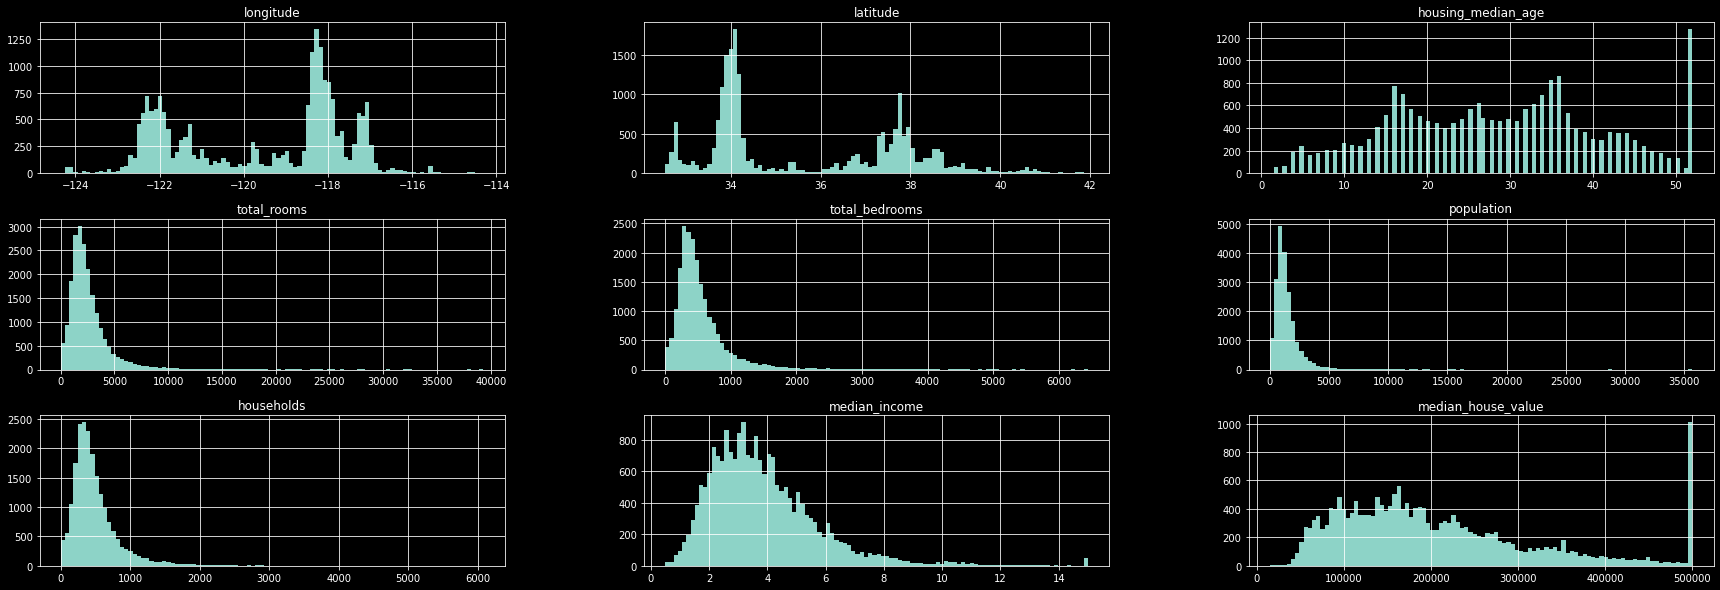

In [167]:
housing.hist(bins=100,figsize=(30,10));

# Data Splitting

In [168]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace = True)

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_indx, test_indx in split.split(housing,housing["income_cat"]):
    strat_train_set = housing.loc[train_indx]
    strat_test_set = housing.loc[test_indx]
    
print(housing["income_cat"].value_counts() / len(housing))
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

[set_.drop("income_cat",axis=1,inplace=True) for set_ in (strat_test_set, strat_train_set)];

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114341
1.0    0.039971
Name: income_cat, dtype: float64


# In depth Visualization

In [169]:
housing = strat_train_set.copy()

### Observation of the geographical distribution of the data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

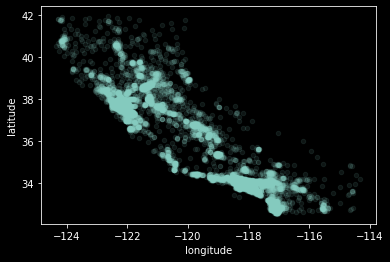

In [170]:
housing.plot(kind="scatter",x = "longitude", y = "latitude",alpha = 0.1)

## Observation of geographical data along population lines with housing prices

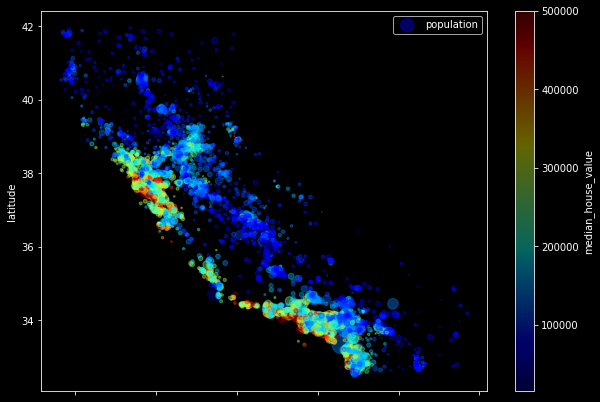

In [171]:
housing.plot(kind='scatter',x='longitude',y='latitude',alpha = 0.4, s= housing["population"]/100,label = 'population',figsize=(10,7),c= "median_house_value",cmap = plt.get_cmap('jet'),colorbar=True);
plt.legend()

## Identification of interesting features - correlation

In [172]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

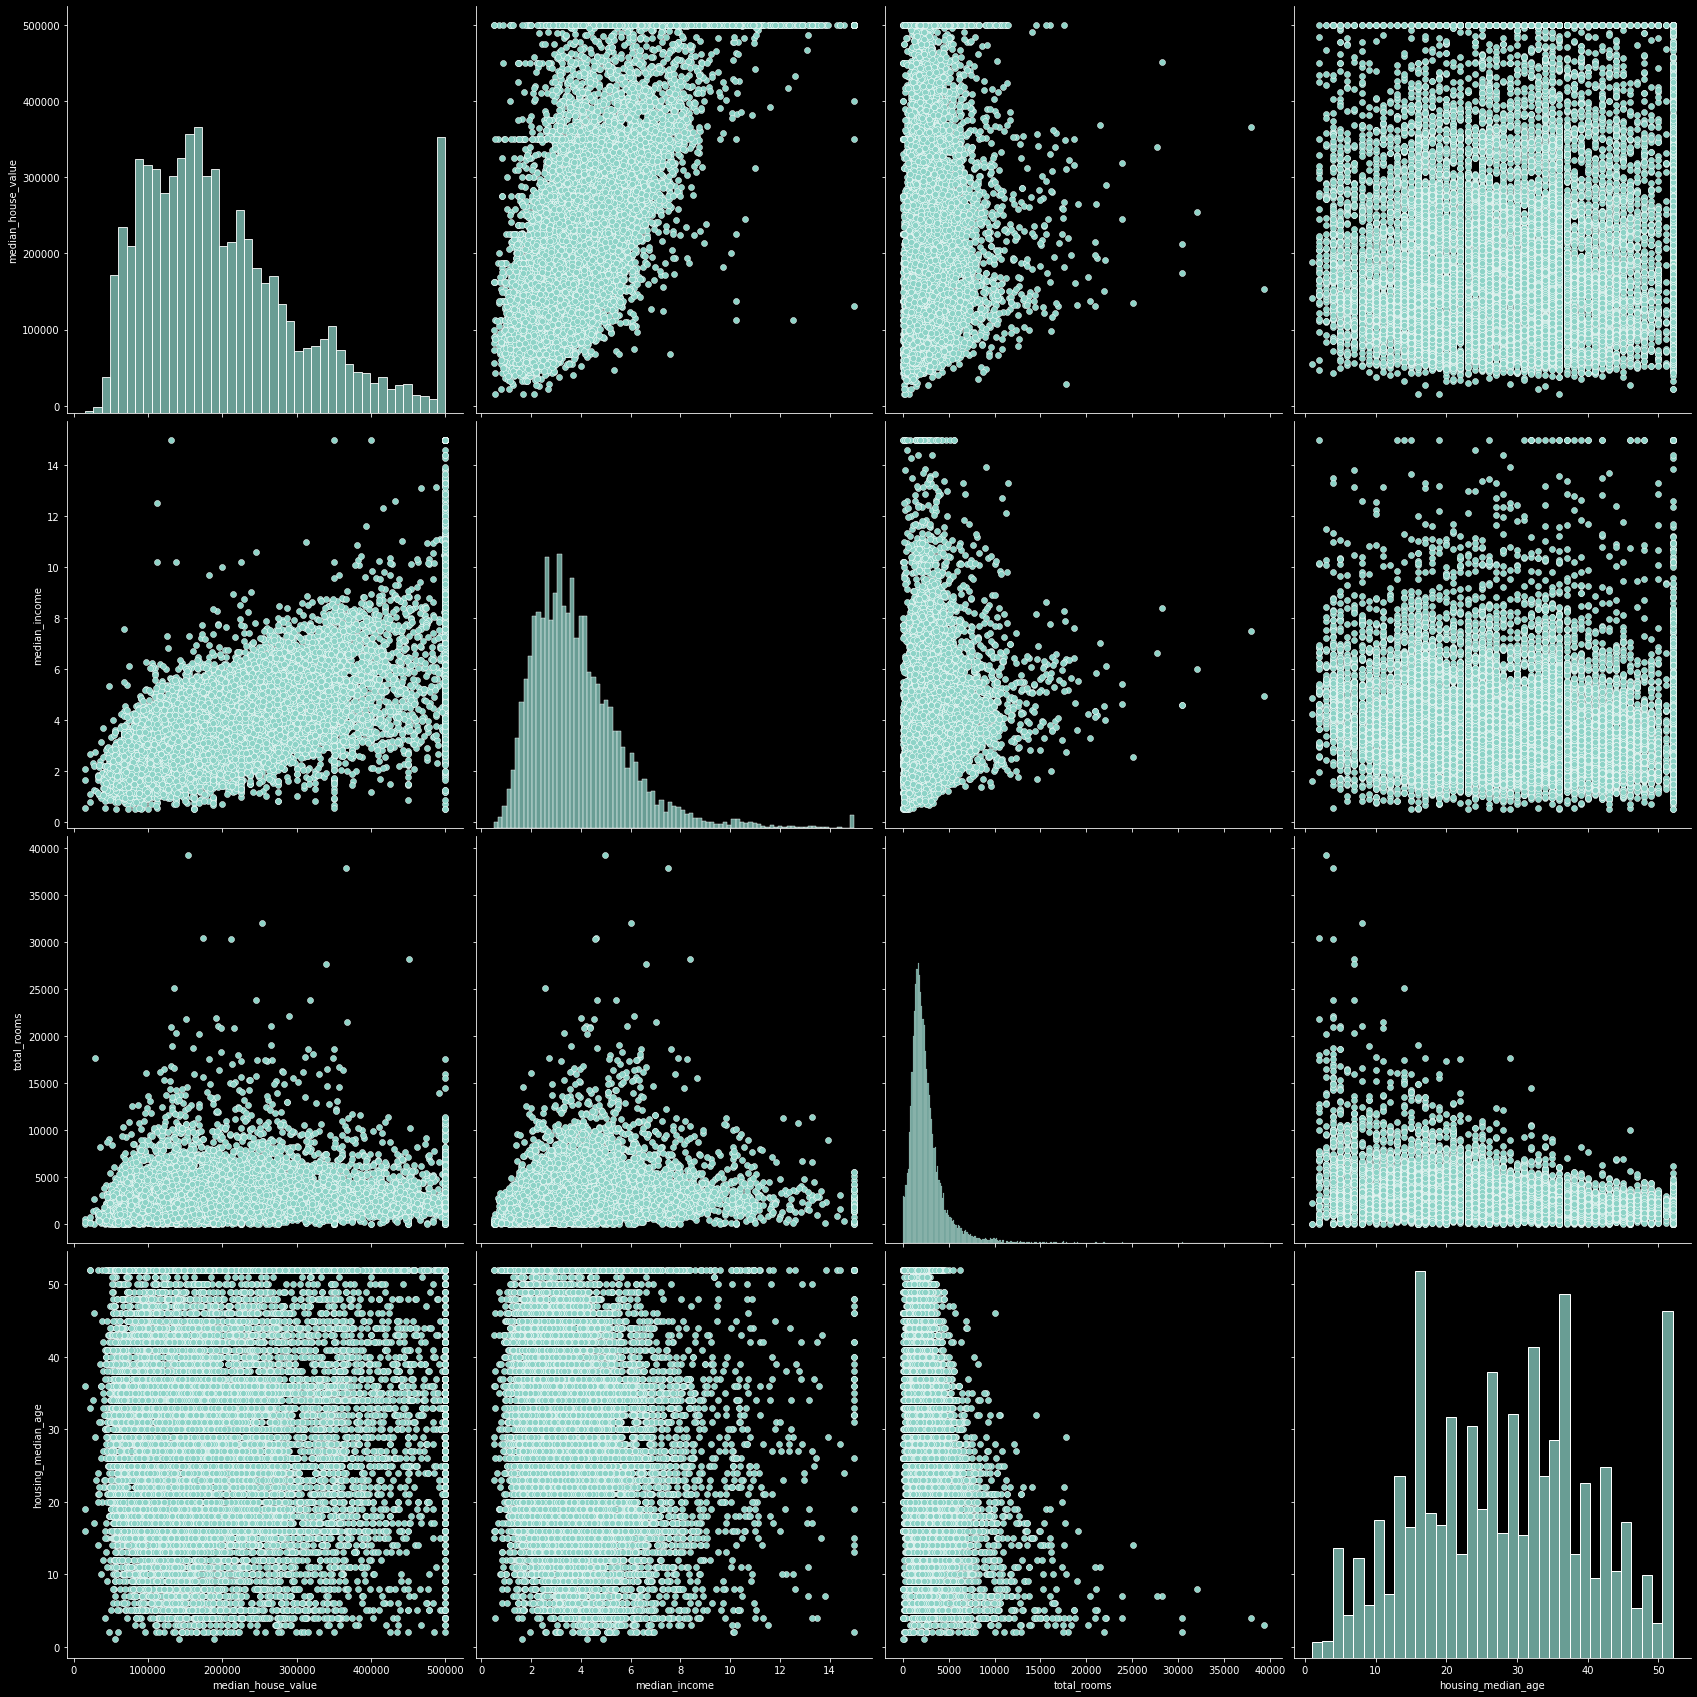

In [173]:
sns.pairplot(housing[attributes],height = 6)

#### Generate extra features normalizing rooms and population by households

rooms per household is more correlated with expensive homes
however, bedrooms per household is inversely correlated with expensive homes

In [174]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_household'] = housing['total_bedrooms'] / housing['households']
housing['population_per_household'] = housing['population'] / housing['households']

In [175]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
bedrooms_per_household     -0.043349
longitude                  -0.047466
latitude                   -0.142673
Name: median_house_value, dtype: float64

# Address Missing Values

In [176]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

### Address numerical missing values

In [177]:
imputer = SimpleImputer(strategy = 'median')
housing_num = housing.drop('ocean_proximity',axis=1) #drop categorical data
imputer.fit(housing_num)

housing_tr = pd.DataFrame(imputer.transform(housing_num),columns = housing_num.columns) #generate training dataframe with imputed values

##### Generate Pipeline

In [178]:
num_attrs = list(housing_num)

num_pipeline = Pipeline([
    ('selector',mine.DataFrameSelector(num_attrs)),
    ('imputer',SimpleImputer(strategy='median')),
    ('attribs_adder',mine.CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

### Address categorical values

In [179]:
housing_cat = housing[['ocean_proximity']]

In [211]:
#Encode  data into one hot encoding
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

##### Generate Pipeline

In [181]:
cat_attrs = ['ocean_proximity']

cat_pipeline = Pipeline([
    ('selector',mine.DataFrameSelector(cat_attrs)),
    ('cat_encoder',OneHotEncoder())
])

### Merging of Pipelines

In [182]:
full_pipeline = ColumnTransformer([
                            ('num_pipeline',num_pipeline,num_attrs),
                            ('cat_pipeline',cat_pipeline,cat_attrs),
])
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

# Model Fitting

## Linear Model

In [187]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression()

In [189]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions: ",lin_reg.predict(some_data_prepared))

print('Labels: ',list(some_labels))

Predictions:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094]
Labels:  [72100.0, 279600.0, 82700.0, 112500.0]


In [190]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [206]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
lin_reg_rmse_scores = np.sqrt(-scores)
print('Scores:',lin_reg_rmse_scores)
print('Mean:',lin_reg_rmse_scores.mean())
print('Standard Deviation:',lin_reg_rmse_scores.std())

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard Deviation: 2880.3282098180666


## Decision tree Regressor

In [197]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)
tree_housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, tree_housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [205]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print('Scores:',tree_rmse_scores)
print('Mean:',tree_rmse_scores.mean())
print('Standard Deviation:',tree_rmse_scores.std())

Scores: [73678.27773892 69636.96783074 68750.19053626 71917.5609797
 69474.63400054 77710.76145688 72067.99044686 73503.44627112
 68909.97463913 70760.81054042]
Mean: 71641.06144405699
Standard Deviation: 2646.116334600287


## Random Forest 

In [209]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)

forest_reg_mse_score = mean_squared_error(housing_labels,housing_predictions)
forest_reg_rmse_score = np.sqrt(forest_reg_mse_score)
print(forest_reg_rmse_score)


18625.950136089337


In [210]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv =10)
forest_rmse_scores = np.sqrt(-scores)
print('Scores:',forest_rmse_scores)
print('Mean:',forest_rmse_scores.mean())
print('Standard Deviation:',forest_rmse_scores.std())

Scores: [51004.0309822  49434.24707408 46783.11475945 52225.1308248
 47604.41717239 52089.12124228 52658.26425325 49848.75353772
 48456.37533059 53954.95551271]
Mean: 50405.84106894548
Standard Deviation: 2240.4816870758573
